In [2]:
import os
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from skimage import io, transform
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [4]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader, Subset, RandomSampler
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
import torch.optim as optim

# Dataset

In [5]:
def train_val_dataset(dataset, val_split=0.25):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

## Irma

In [2]:
!wget -nc https://www.dropbox.com/s/39vs6jh9ivbk866/patches_completo.zip
!mkdir datasets\IRMA
!unzip -u -q patches_completo.zip -d ./datasets/IRMA

File 'patches_completo.zip' already there; not retrieving.



The syntax of the command is incorrect.


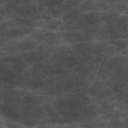

In [4]:
im1 = Image.open('./datasets/IRMA/p_d_left_cc(1).png')
im1

### Using numpy

In [ ]:
def import_irma(path='./datasets/IRMA/', imshape=(128,128)):
    images = []
    labels = []

    with open(path+'featureS.txt', 'r') as paths:
        next_path = paths.readline()
        while next_path:
            label = paths.readline()

            next_path, label = next_path[:-1], label[:-1] # remove \n

            im = Image.open(path + next_path + '.png')
            imarr = np.asarray(im)

            images.append(imarr)
            labels.append(label)

            next_path = paths.readline()

    return np.asarray(images), np.asarray(labels)

irma = import_irma()
irma[0].shape, irma[1].shape

((5024, 128, 128), (5024,))

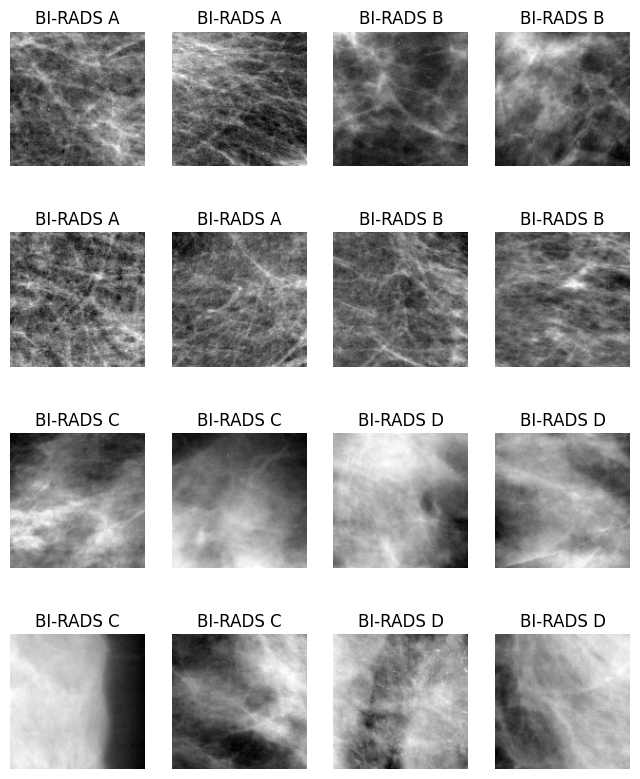

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(8, 10))
unique_classes = np.unique(irma[1])

irma_classmap = {
    '0': 'BI-RADS A',
    '1': 'BI-RADS B',
    '2': 'BI-RADS C',
    '3': 'BI-RADS D'
}

for i, c in enumerate(unique_classes):
    sample_class = np.random.choice(np.where(irma[1] == c)[0], 4, replace=False)

    for j, sample_index in enumerate(sample_class):
        cell = axs[(i//2)*2 + (j//2)][(i%2)*2 + (j%2)]
        cell.imshow(irma[0][sample_index, :], cmap='gray')
        cell.axis('off')
        cell.set_title(irma_classmap[irma[1][sample_index]])
    # ax.axis('off')
    # ax.set_title(pieces_encoder.inverse_transform([l])[0])

### Using torch Dataset

In [6]:
class IrmaDataset(Dataset):
    irma_classmap = {
        0: 'BI-RADS A',
        1: 'BI-RADS B',
        2: 'BI-RADS C',
        3: 'BI-RADS D'
    }

    def __init__(self, metadata_file='featureS.txt', root_dir='./datasets/IRMA/', transform=None):
        """
        Arguments:
            csv_file (string): Path to the metadata file.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.metadata_frame = self._read_metadata(root_dir, metadata_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.metadata_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.metadata_frame.iloc[idx, 0] + '.png')
        image = io.imread(img_name)
        label = int(self.metadata_frame.iloc[idx, 1])
        # label = np.array(label, dtype=float)
        sample = {'image': image, 'label': label}

        if self.transform:
            sample['image'] = self.transform(sample['image'])

        return sample


    def _read_metadata(self, root_dir, metadata_file):
        files_metadatas = []

        with open(root_dir+metadata_file, 'r') as paths:
            next_path = paths.readline()

            while next_path:
                label = paths.readline()
                next_path, label = next_path[:-1], label[:-1] # remove '\n'
                files_metadatas.append((next_path, label))

                next_path = paths.readline()

        return pd.DataFrame(files_metadatas, columns=['file_name', 'label'])


0 (128, 128) 0
1 (128, 128) 0
2 (128, 128) 0
3 (128, 128) 0


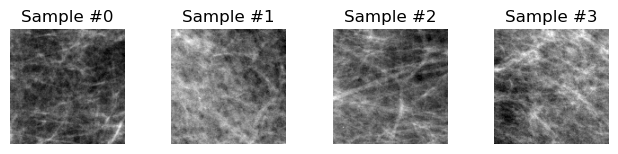

In [7]:
irma_dataset = IrmaDataset()

fig = plt.figure()

for i, sample in enumerate(irma_dataset):
    print(i, sample['image'].shape, sample['label'])

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title(f'Sample #{i}')
    ax.axis('off')
    ax.imshow(sample['image'], cmap='gray')

    if i == 3:
        plt.show()
        break


In [8]:
dataloader = DataLoader(irma_dataset, batch_size=4,
                        shuffle=True, num_workers=0)

0 torch.Size([4, 128, 128]) torch.Size([4])
1 torch.Size([4, 128, 128]) torch.Size([4])
2 torch.Size([4, 128, 128]) torch.Size([4])
3 torch.Size([4, 128, 128]) torch.Size([4])


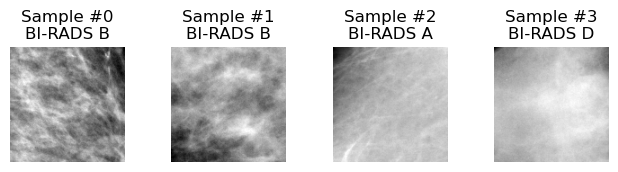

In [9]:
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
            sample_batched['label'].size())

    # break

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()

        for i, (sample_image, sample_label) in enumerate(zip(sample_batched['image'], sample_batched['label'])):
            ax = plt.subplot(1, 4, i + 1)
            plt.tight_layout()
            ax.set_title(f'Sample #{i}\n{IrmaDataset.irma_classmap[int(sample_label.item())]}')
            ax.axis('off')
            ax.imshow(sample_image, cmap='gray')

        plt.show()
        break


## VisTex

In [8]:
!wget -nc https://vismod.media.mit.edu/pub/VisTex/VisTex.tar.gz
!mkdir datasets\VisTex
!tar -xzvf ./VisTex.tar.gz -C ./datasets/VisTex

File 'VisTex.tar.gz' already there; not retrieving.

A subdirectory or file datasets\VisTex already exists.
x VisionTexture/buildVisTex
x VisionTexture/vistex1.0a.A.tar.Z
x VisionTexture/vistex1.0a.B.tar.Z
x VisionTexture/vistex1.0a.C.tar.Z
x VisionTexture/vistex1.0a.D.tar.Z
x VisionTexture/vistex1.0a.E.tar.Z
x VisionTexture/vistex1.0a.F.tar.Z
x VisionTexture/vistex1.0a.G.tar.Z
x VisionTexture/vistex1.0a.H.tar.Z


In [6]:
%%bash

cd datasets/VisTex/VisionTexture/
bash buildVisTex

Uncompressing the VisTex database . . .
Starting directory structure
Starting Reference Textures
Starting Texture Scenes


./datasets/VisTex/VisionTexture/VisTex/FLAT/128x128/Stone.0005.ppm


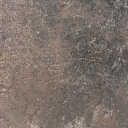

In [ ]:
for p in glob.glob(os.path.join("./datasets/VisTex/VisionTexture/VisTex/FLAT/128x128","*.ppm")):
    im1 = Image.open(p)
    break
print(p)
im1

In [ ]:
os.path.join("./datasets/VisTex/VisionTexture/VisTex/FLAT/128x128","*.ppm")

'./datasets/VisTex/VisionTexture/VisTex/FLAT/128x128/*.ppm'

In [ ]:
class VisTexDataset(Dataset):
    def __init__(self, root_dir='./datasets/VisTex/VisionTexture/VisTex/Images/Reference/*', transform=None, return_images=False, include_classes=None, exclude_classes=None):
        """
        Arguments:
            csv_file (string): Path to the metadata file.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.metadata_frame = self._read_metadata(root_dir, return_images, include_classes, exclude_classes)
        self.label_encoder = self._encode_labels()
        self.return_images = return_images
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.metadata_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        if self.return_images:
            image = self.metadata_frame.iloc[idx, 0]
        else:
            image = io.imread(self.metadata_frame.iloc[idx, 0])
        label = self.metadata_frame.iloc[idx, 1]
        # label = np.array(label, dtype=float)
        sample = {'image': image, 'label': label}

        if self.transform:
            sample['image'] = self.transform(sample['image'])

        return sample

    def transform_label(self, label):
        return self.label_encoder.inverse_transform(label)

    def _encode_labels(self):
        label_encoder = LabelEncoder()
        self.metadata_frame['label'] = label_encoder.fit_transform(self.metadata_frame['label'])
        return label_encoder

    def _read_metadata(self, root_dir, return_images=False, include_classes=None, exclude_classes=None):
        files_metadatas = []

        for p in glob.glob(os.path.join(root_dir, '*.ppm')):
            label = p.split('/')[-1].split('.')[0]
            if include_classes and label not in include_classes:
                continue
            if exclude_classes and label in exclude_classes:
                continue
            path = p
            if (return_images):
                im = io.imread(path)
                files_metadatas.append((im, label))
            else:
                files_metadatas.append((path, label))

        return pd.DataFrame(files_metadatas, columns=['file', 'label'])


In [ ]:
ds = VisTexDataset(root_dir="/content/datasets/VisTex/VisionTexture/VisTex/FLAT/128x128",include_classes=['Bark', "Brick", "Leaves", "Tile"],return_images=True)
len(ds)

50

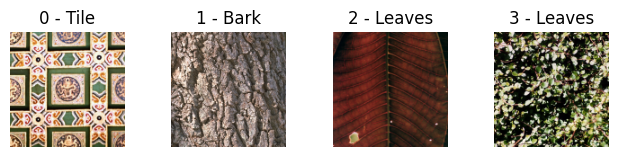

In [ ]:
vt_dataset = VisTexDataset(root_dir="/content/datasets/VisTex/VisionTexture/VisTex/FLAT/128x128", include_classes=['Bark', "Brick", "Leaves", "Tile"],return_images=True)

fig = plt.figure()

for i, sample in enumerate(vt_dataset):
    # print(i, sample['image'].shape, sample['label'])

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title(f'{i} - {vt_dataset.transform_label([sample["label"]])[0]}')
    ax.axis('off')
    ax.imshow(sample['image'])

    if i == 3:
        plt.show()
        break

## DTD
https://www.robots.ox.ac.uk/~vgg/data/dtd/

In [ ]:
!wget -nc https://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.0.1.tar.gz
!mkdir -p ./datasets/DTD
!tar -xzf ./dtd-r1.0.1.tar.gz -C ./datasets/DTD

--2023-11-08 12:58:14--  https://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.0.1.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/datasets/dtd/dtd-r1.0.1.tar.gz [following]
--2023-11-08 12:58:14--  https://thor.robots.ox.ac.uk/datasets/dtd/dtd-r1.0.1.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 625239812 (596M) [application/octet-stream]
Saving to: ‘dtd-r1.0.1.tar.gz’

dtd-r1.0.1.tar.gz   100%[===================>] 596.27M  27.6MB/s    in 23s     

2023-11-08 12:58:38 (25.9 MB/s) - ‘dtd-r1.0.1.tar.gz’ saved [625239812/625239812]



./datasets/DTD/dtd/images/lined/lined_0123.jpg


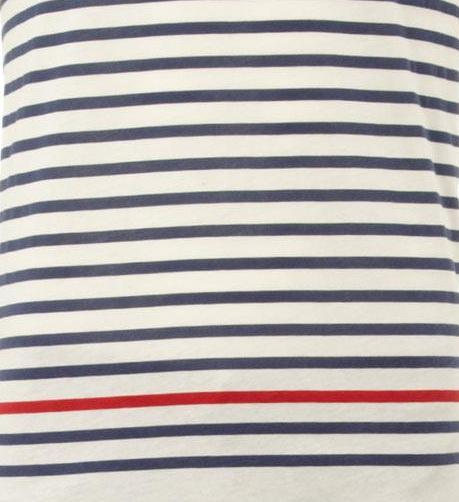

In [ ]:
for p in glob.glob(os.path.join("./datasets/DTD/dtd/images/*/","*.jpg")):
    # print(p)
    im1 = Image.open(p)
    break
print(p)
im1

In [ ]:
class DTDDataset(Dataset):
    def __init__(self, root_dir='./datasets/DTD/dtd/images/*', transform=None, return_images=False, include_classes=None, exclude_classes=None):
        """
        Arguments:
            csv_file (string): Path to the metadata file.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.transform = transform
        self.metadata_frame = self._read_metadata(root_dir, return_images, include_classes, exclude_classes)
        self.label_encoder = self._encode_labels()
        self.return_images = return_images
        self.root_dir = root_dir

    def __len__(self):
        return len(self.metadata_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        if self.return_images:
            image = self.metadata_frame.iloc[idx, 0]
        else:
            image = io.imread(self.metadata_frame.iloc[idx, 0])
            if self.transform:
                image = self.transform(image)

        label = self.metadata_frame.iloc[idx, 1]
        # label = np.array(label, dtype=float)
        sample = {'image': image, 'label': label}

        return sample

    def transform_label(self, label):
        return self.label_encoder.inverse_transform(label)

    def _encode_labels(self):
        label_encoder = LabelEncoder()
        self.metadata_frame['label'] = label_encoder.fit_transform(self.metadata_frame['label'])
        return label_encoder

    def _read_metadata(self, root_dir, return_images=False, include_classes=None, exclude_classes=None):
        files_metadatas = []

        for p in glob.glob(os.path.join(root_dir, '*.jpg')):
            label = p.split('/')[-1].split('_')[0]
            if include_classes and label not in include_classes:
                continue
            if exclude_classes and label in exclude_classes:
                continue
            path = p
            if (return_images):
                im = io.imread(path)
                files_metadatas.append((self.transform(im), label))
            else:
                files_metadatas.append((path, label))

        return pd.DataFrame(files_metadatas, columns=['file', 'label'])


In [ ]:
ds = DTDDataset(return_images=False)
len(ds)

5640

In [ ]:
for d in ds:
    print(d["image"])
    break

[[[167 163 164]
  [148 144 145]
  [128 123 127]
  ...
  [237 231 217]
  [232 226 212]
  [231 222 207]]

 [[156 152 153]
  [137 133 134]
  [121 116 120]
  ...
  [233 229 217]
  [235 229 215]
  [236 228 215]]

 [[154 150 149]
  [135 131 130]
  [124 120 121]
  ...
  [227 223 212]
  [232 225 215]
  [236 229 219]]

 ...

 [[236 233 226]
  [236 233 226]
  [236 233 226]
  ...
  [221 217 205]
  [221 217 205]
  [221 217 205]]

 [[233 230 223]
  [233 230 223]
  [233 230 223]
  ...
  [221 217 205]
  [221 217 205]
  [221 217 205]]

 [[230 227 220]
  [230 227 220]
  [230 227 220]
  ...
  [222 218 206]
  [222 218 206]
  [222 218 206]]]


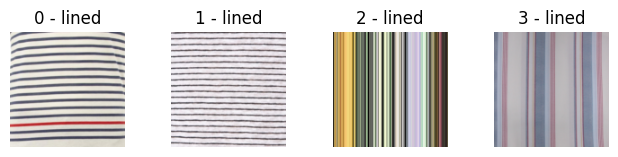

In [ ]:
dtd_dataset = DTDDataset(transform=transforms.Compose([transforms.ToTensor(),
                                    transforms.Resize((128,128), antialias=True)]))

fig = plt.figure()

for i, sample in enumerate(dtd_dataset):
    # print(i, sample['image'].shape, sample['label'])

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title(f'{i} - {dtd_dataset.transform_label([sample["label"]])[0]}')
    ax.axis('off')
    ax.imshow(sample['image'].permute(1, 2, 0))

    if i == 3:
        plt.show()
        break

# Model

In [10]:
class MinMaxScaler(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, min=0, max=1):
        self.min = min
        self.max = max

    def __call__(self, sample):
        image = sample

        min = torch.min(image)
        max = torch.max(image)

        img = (image - min) / (max - min)
        img = img * (self.max - self.min) + self.min

        return img


## Dataset Prep

In [11]:
# batch_size = 32

# dataset = VisTexDataset(root_dir='./datasets/VisTex/VisionTexture/VisTex/FLAT/128x128',
#                         # include_classes=['Bark', "Brick", "Leaves", "Water"],
#                         transform=transforms.Compose([transforms.ToTensor(),
#                                                       transforms.Grayscale(num_output_channels=1),
#                                                     #   transforms.Normalize((0.5,), (0.5,))
#                                                       ]))

# dataloader = DataLoader(dataset, batch_size=batch_size,
#                         shuffle=True, num_workers=0)

In [12]:
batch_size = 32

dataset = IrmaDataset(transform=transforms.Compose([transforms.ToTensor(),
                                                    MinMaxScaler()
                                                    #   transforms.Grayscale(num_output_channels=1),
                                                    #   transforms.Normalize((0.5,), (0.5,))
                                                    ]))

dataloader = DataLoader(dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0)

In [ ]:
# batch_size = 32

# dataset = DTDDataset(return_images=True,
#                      include_classes=['blotchy', 'banded', 'chequered', 'cracked', 'dotted',
#                                       'fibrous', 'honeycombed', 'lined', 'marbled', 'porous',
#                                       'smeared', 'stained', 'striped', 'veined', 'waffled'],
#                     transform=transforms.Compose([transforms.ToTensor(),
#                                                     transforms.Resize((128,128), antialias=True),
#                                                     MinMaxScaler(),
#                                                     transforms.Grayscale(num_output_channels=1),
#                                                     #   transforms.Normalize((0.5,), (0.5,))
#                                                     ]))

# dataloader = DataLoader(dataset, batch_size=batch_size,
#                         shuffle=True, num_workers=0)

In [13]:
for i in dataset:
    print(i['image'].shape)
    n_channels = i['image'].shape[0]
    # npimg = np.asarray(i['image'])
    print(torch.min(i['image']))
    print(torch.max(i['image']))
    break

torch.Size([1, 128, 128])
tensor(0.)
tensor(1.)


torch.Size([32, 1, 128, 128])


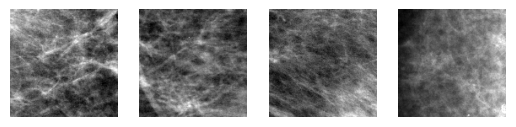

In [14]:
def imshow(imgs):
    print(imgs.shape)

    fig, axs = plt.subplots(1, 4)

    for ax, img in zip(axs.ravel(), imgs):
        img = img / 2 + 0.5     # unnormalize
        # print(img)

        ax.imshow(img[0], cmap='gray')
        ax.axis('off')
    plt.show()

# get some random training images
for dataiter in dataloader:
    images, labels = dataiter['image'], dataiter['label']

    # show images
    imshow(images)
    break

In [15]:
datasets = train_val_dataset(dataset, 0.1)
datasets['test'] = datasets['val']
datasets = {**datasets, **train_val_dataset(datasets['train'], 0.1/0.9)}

In [16]:
len(datasets['train']), len(datasets['test']), len(datasets['val'])

(4018, 503, 503)

In [17]:
dataloaders = {x:DataLoader(datasets[x], batch_size, shuffle=True) for x in ['train','test','val']}

## Simple ConvNet for classification

In [16]:
nclasses = 4 if type(dataset) == IrmaDataset else len(dataset.label_encoder.classes_)

In [27]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 256, 3)
        self.bn1 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(256, 128, 3)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 64, 3)
        self.bn3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, nclasses)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), 1)
        return x

net = ConvNet()

In [28]:
summary(net, input_size=(8, 1, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
ConvNet                                  [8, 4]                    --
├─Conv2d: 1-1                            [8, 256, 126, 126]        2,560
├─BatchNorm2d: 1-2                       [8, 256, 126, 126]        512
├─MaxPool2d: 1-3                         [8, 256, 63, 63]          --
├─Conv2d: 1-4                            [8, 128, 61, 61]          295,040
├─BatchNorm2d: 1-5                       [8, 128, 61, 61]          256
├─MaxPool2d: 1-6                         [8, 128, 30, 30]          --
├─Conv2d: 1-7                            [8, 64, 28, 28]           73,792
├─BatchNorm2d: 1-8                       [8, 64, 28, 28]           128
├─MaxPool2d: 1-9                         [8, 64, 14, 14]           --
├─Linear: 1-10                           [8, 128]                  1,605,760
├─Linear: 1-11                           [8, 64]                   8,256
├─Linear: 1-12                           [8, 4]             

In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device)

for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(dataloaders['train'], 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data['image'].to(device), data['label'].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    print(f'[epoch: {epoch + 1}] train\t\t - loss: {running_loss / len(dataloaders["train"]):.3f} \t - accuracy: {100 * correct // total} %')

    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for i, data in enumerate(dataloaders['val'], 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data['image'].to(device), data['label'].to(device)

            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs, labels)

            running_loss += loss.item()

        print(f'[epoch: {epoch + 1}] validation\t - loss: {running_loss / len(dataloaders["val"]):.3f} \t - accuracy: {100 * correct // total} %')

    running_loss = 0.0

print('Finished Training')

[epoch: 1] train		 - loss: 1.319 	 - accuracy: 41 %
[epoch: 1] validation	 - loss: 1.290 	 - accuracy: 43 %
[epoch: 2] train		 - loss: 1.292 	 - accuracy: 44 %
[epoch: 2] validation	 - loss: 1.306 	 - accuracy: 43 %
[epoch: 3] train		 - loss: 1.214 	 - accuracy: 52 %
[epoch: 3] validation	 - loss: 1.133 	 - accuracy: 60 %
[epoch: 4] train		 - loss: 1.144 	 - accuracy: 58 %
[epoch: 4] validation	 - loss: 1.141 	 - accuracy: 59 %
[epoch: 5] train		 - loss: 1.134 	 - accuracy: 60 %
[epoch: 5] validation	 - loss: 1.190 	 - accuracy: 53 %
[epoch: 6] train		 - loss: 1.143 	 - accuracy: 58 %
[epoch: 6] validation	 - loss: 1.143 	 - accuracy: 59 %
[epoch: 7] train		 - loss: 1.119 	 - accuracy: 62 %
[epoch: 7] validation	 - loss: 1.161 	 - accuracy: 58 %
[epoch: 8] train		 - loss: 1.114 	 - accuracy: 62 %
[epoch: 8] validation	 - loss: 1.114 	 - accuracy: 62 %
[epoch: 9] train		 - loss: 1.100 	 - accuracy: 63 %
[epoch: 9] validation	 - loss: 1.119 	 - accuracy: 61 %
[epoch: 10] train		 - loss: 

In [22]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in dataloaders['test']:
        inputs, labels = data['image'].to(device), data['label'].to(device)
        # calculate outputs by running images through the network
        outputs = net(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {len(datasets["test"])} test images: {100 * correct // total} %')

Accuracy of the network on the 503 test images: 45 %


## Utility Functions

### Loss functions

In [18]:
def get_kl_loss(mean, logvar):
    kl_loss = -0.5 * torch.mean(1 + logvar - mean.pow(2) - logvar.exp())

    return kl_loss

def get_reconstruction_loss(y_true, y_pred, device='cuda'):
    reconstruction_loss = F.mse_loss(y_pred, y_true, reduction='sum').to(device)
    reconstruction_loss = reconstruction_loss/y_pred.shape[0]

    return reconstruction_loss

def embedding_loss(y_true, y_pred, same, device='cuda'):
    return nn.CosineEmbeddingLoss()(y_true, y_pred, torch.Tensor([1 if list(same) else -1]).to(device))

### Training Function

In [19]:
def validate(model, data, val_rand_loader=None):
    running_metrics = {'loss': 0.0}

    with torch.no_grad():
        for i, data in enumerate(data, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data['image'].to(device), data['label'].to(device)

            if val_rand_loader:
                rand_batch = next(iter(val_rand_loader))
                rand_inputs, rand_labels = rand_batch['image'].to(device), rand_batch['label'].to(device)
                if inputs.shape[0] != rand_inputs.shape[0]:
                    rand_inputs = rand_inputs[:inputs.shape[0]]
                    rand_labels = rand_labels[:inputs.shape[0]]
                outputs = model(inputs, rand_inputs)
            else:
                outputs = model(inputs)

            loss = outputs[-1]
            metrics = outputs[-2]

            running_metrics['loss'] += loss.item()

            for metric in metrics.items():
                running_metrics.setdefault(metric[0], 0)
                running_metrics[metric[0]] += metric[1].item()

    return running_metrics

In [20]:
def get_metrics_str(metrics, size, prefix):
    return "".join([f" - {prefix}{l[0]}: {(l[1]/size):.4f}" for l in metrics.items()])

def train(model, optimizer, train_data, val_data, epochs, SSL=None, device='cuda'):
    hist_metrics = []

    if SSL:
        train_rand_loader, val_rand_loader = SSL

    for epoch in range(epochs):  # loop over the dataset multiple times

        train_metrics = {'loss': 0.0}

        for i, data in enumerate(train_data, 0):
            inputs, labels = data['image'].to(device), data['label'].to(device)

            optimizer.zero_grad()

            if SSL:
                rand_batch = next(iter(train_rand_loader))
                rand_inputs, rand_labels = rand_batch['image'].to(device), rand_batch['label'].to(device)
                if inputs.shape[0] != rand_inputs.shape[0]:
                    rand_inputs = rand_inputs[:inputs.shape[0]]
                outputs = model(inputs, rand_inputs)
            else:
                outputs = model(inputs)

            loss = outputs[-1]
            metrics = outputs[-2]

            loss.backward()

            train_metrics['loss'] += loss.item()
            for metric in metrics.items():
                train_metrics.setdefault(metric[0], 0.0)
                train_metrics[metric[0]] += metric[1].item()

            optimizer.step()

        if SSL:
            val_metrics = validate(model, val_data, val_rand_loader)
        else:
            val_metrics = validate(model, val_data)

        hist_metrics.append((train_metrics, val_metrics))
        print(f'[epoch: {epoch+1}]{get_metrics_str(train_metrics, len(train_data), "train_")}{get_metrics_str(val_metrics, len(val_data), "val_")}')

    print('Finished Training')
    return hist_metrics

## Autoencoder

In [43]:
class Autoencoder(nn.Module):
    def __init__(self, device=None):
        super().__init__()
        if device is None:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = device

        self.encoder = nn.Sequential(
            nn.Conv2d(n_channels, 128, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 96, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(1),
            nn.Linear(96 * 30 * 30, 768),
            nn.ReLU(),
            nn.Linear(768, 384),
            nn.ReLU(),
            nn.Linear(384, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
        )
        self.distribution_mean = nn.Linear(64, 32)
        self.distribution_variance = nn.Linear(64, 32)

        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 384),
            nn.ReLU(),
            nn.Linear(384, 768),
            nn.ReLU(),
            nn.Linear(768, 96 * 30 * 30),
            nn.ReLU(),
            torch.nn.Unflatten(1, (96, 30, 30)),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(96, 128, 3),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(128, n_channels, 5),
            nn.Sigmoid(),
        )


    def forward(self, x):
        input = x
        x = self.encoder(x)
        mean, var = self.distribution_mean(x), self.distribution_variance(x)
        x = self.sample_latent_features([mean, var])
        latent = x
        x = self.decoder(x)

        rec_loss = get_reconstruction_loss(input, x)
        kl_loss =  get_kl_loss(mean, var)
        loss = rec_loss + kl_loss

        return x, latent, dict(rec_loss=rec_loss, kl_loss=kl_loss), loss

    def sample_latent_features(self, distribution):
        # if not self.training: return distribution[0]
        distribution_mean, distribution_variance = distribution
        shape = distribution_variance.shape
        batch_size = shape[0]
        random = torch.normal(mean=0, std=1, size=(batch_size, shape[1])).to(self.device)
        return distribution_mean + torch.exp(0.5 * distribution_variance) * random

ae = Autoencoder()

In [50]:
summary(ae, input_size=(32, n_channels, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder                              [32, 1, 128, 128]         --
├─Sequential: 1-1                        [32, 64]                  --
│    └─Conv2d: 2-1                       [32, 128, 124, 124]       3,328
│    └─ReLU: 2-2                         [32, 128, 124, 124]       --
│    └─MaxPool2d: 2-3                    [32, 128, 62, 62]         --
│    └─Conv2d: 2-4                       [32, 96, 60, 60]          110,688
│    └─ReLU: 2-5                         [32, 96, 60, 60]          --
│    └─MaxPool2d: 2-6                    [32, 96, 30, 30]          --
│    └─Flatten: 2-7                      [32, 86400]               --
│    └─Linear: 2-8                       [32, 768]                 66,355,968
│    └─ReLU: 2-9                         [32, 768]                 --
│    └─Linear: 2-10                      [32, 384]                 295,296
│    └─ReLU: 2-11                        [32, 384]              

In [45]:
optimizer = optim.Adam(ae.parameters())

In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ae.to(device)

hist = train(ae, optimizer, dataloaders['train'], dataloaders['val'], 10)
# hist = train(ae, optimizer, dataloader, dataloader, 20)

[epoch: 1] - train_loss: 606.6150 - train_rec_loss: 605.3110 - train_kl_loss: 1.3040 - val_loss: 533.2760 - val_rec_loss: 531.8406 - val_kl_loss: 1.4354
[epoch: 2] - train_loss: 451.3487 - train_rec_loss: 449.1305 - train_kl_loss: 2.2182 - val_loss: 370.4193 - val_rec_loss: 366.6557 - val_kl_loss: 3.7636
[epoch: 3] - train_loss: 343.9814 - train_rec_loss: 341.2877 - train_kl_loss: 2.6938 - val_loss: 336.1510 - val_rec_loss: 333.6468 - val_kl_loss: 2.5042
[epoch: 4] - train_loss: 339.3083 - train_rec_loss: 336.9650 - train_kl_loss: 2.3433 - val_loss: 336.5151 - val_rec_loss: 334.3099 - val_kl_loss: 2.2052
[epoch: 5] - train_loss: 338.1083 - train_rec_loss: 335.8167 - train_kl_loss: 2.2915 - val_loss: 340.6776 - val_rec_loss: 338.0877 - val_kl_loss: 2.5899
[epoch: 6] - train_loss: 292.1042 - train_rec_loss: 289.2696 - train_kl_loss: 2.8346 - val_loss: 258.8774 - val_rec_loss: 255.9606 - val_kl_loss: 2.9168
[epoch: 7] - train_loss: 255.5506 - train_rec_loss: 252.9348 - train_kl_loss: 2.61

In [47]:
test_metrics = validate(ae, dataloaders['test'])

print(get_metrics_str(test_metrics, len(dataloaders['test']), 'test_'))

 - test_loss: 259.5767 - test_rec_loss: 257.3796 - test_kl_loss: 2.1970


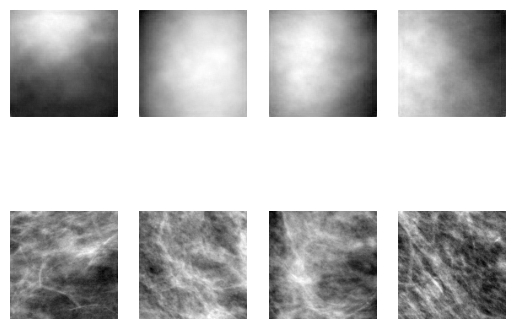

In [48]:
fig, axs = plt.subplots(2, 4)
inv_normalize = transforms.Normalize((-1,), (2,))

with torch.no_grad():
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data['image'].to(device), data['label'].to(device)

        outputs = ae(inputs)

        for ax, reconstructed, original in zip(range(4), outputs[0], inputs):
            reconstructed = inv_normalize(reconstructed)      # unnormalize
            original = inv_normalize(original)                # unnormalize
            # original = original / 2 + 0.5     # unnormalize
            # print(reconstructed[0])
            # print(original[0])

            axs[0][ax].imshow(reconstructed[0].cpu(), cmap='gray')
            # axs[0][ax].imshow(reconstructed.cpu().permute(1,2,0))
            axs[1][ax].imshow(original[0].cpu(), cmap='gray')
            # axs[1][ax].imshow(original.cpu().permute(1,2,0))
            axs[0][ax].axis('off')
            axs[1][ax].axis('off')
        plt.show()

        break

## Autoencoder 2

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, device=None):
        super().__init__()
        if device is None:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = device

        self.encoder = nn.Sequential(
            nn.Conv2d(n_channels, 256, 5),
            # nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(256, 128, 3),
            # nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 64, 3),
            # nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(1),
            nn.Linear(64 * 14 * 14, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
        )
        self.distribution_mean = nn.Linear(64, 32)
        self.distribution_variance = nn.Linear(64, 32)

        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            torch.nn.Unflatten(1, (128, 1, 1)),
            nn.ConvTranspose2d(128, 64, 14),
            # nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(64, 128, 3),
            # nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(128, 256, 3),
            # nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(256, n_channels, 5),
            nn.Sigmoid(),
        )


    def forward(self, x):
        input = x

        x = self.encoder(x)
        mean, var = self.distribution_mean(x), self.distribution_variance(x)
        x = self.sample_latent_features([mean, var])
        latent = x
        x = self.decoder(x)

        rec_loss = get_reconstruction_loss(input, x)
        kl_loss =  get_kl_loss(mean, var)
        loss = rec_loss + kl_loss

        return x, latent, dict(rec_loss=rec_loss, kl_loss=kl_loss), loss

    def sample_latent_features(self, distribution):
        # if not self.training: return distribution[0]
        distribution_mean, distribution_variance = distribution
        shape = distribution_variance.shape
        batch_size = shape[0]
        random = torch.normal(mean=0, std=1, size=(batch_size, shape[1])).to(self.device)
        return distribution_mean + torch.exp(0.5 * distribution_variance) * random

ae = Autoencoder()

In [ ]:
summary(ae, input_size=(32, n_channels, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder                              [32, 1, 128, 128]         --
├─Sequential: 1-1                        [32, 64]                  --
│    └─Conv2d: 2-1                       [32, 256, 124, 124]       6,656
│    └─ReLU: 2-2                         [32, 256, 124, 124]       --
│    └─MaxPool2d: 2-3                    [32, 256, 62, 62]         --
│    └─Conv2d: 2-4                       [32, 128, 60, 60]         295,040
│    └─ReLU: 2-5                         [32, 128, 60, 60]         --
│    └─MaxPool2d: 2-6                    [32, 128, 30, 30]         --
│    └─Conv2d: 2-7                       [32, 64, 28, 28]          73,792
│    └─ReLU: 2-8                         [32, 64, 28, 28]          --
│    └─MaxPool2d: 2-9                    [32, 64, 14, 14]          --
│    └─Flatten: 2-10                     [32, 12544]               --
│    └─Linear: 2-11                      [32, 128]                 1,605,

In [ ]:
optimizer = optim.Adam(ae.parameters())

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ae.to(device)

hist = train(ae, optimizer, dataloaders['train'], dataloaders['val'], 20)
# hist = train(ae, optimizer, dataloader, dataloaders['val'], 100)

[epoch: 1] - train_loss: 145.7213 - train_rec_loss: 142.4028 - train_kl_loss: 3.3185 - val_loss: 149.9780 - val_rec_loss: 146.6250 - val_kl_loss: 3.3530
[epoch: 2] - train_loss: 142.9622 - train_rec_loss: 139.7007 - train_kl_loss: 3.2615 - val_loss: 151.7649 - val_rec_loss: 148.5031 - val_kl_loss: 3.2619
[epoch: 3] - train_loss: 141.8908 - train_rec_loss: 138.6089 - train_kl_loss: 3.2819 - val_loss: 154.4678 - val_rec_loss: 151.1654 - val_kl_loss: 3.3025
[epoch: 4] - train_loss: 141.6650 - train_rec_loss: 138.3845 - train_kl_loss: 3.2805 - val_loss: 150.2794 - val_rec_loss: 147.0154 - val_kl_loss: 3.2640
[epoch: 5] - train_loss: 137.8422 - train_rec_loss: 134.5616 - train_kl_loss: 3.2806 - val_loss: 145.4128 - val_rec_loss: 142.1028 - val_kl_loss: 3.3101
[epoch: 6] - train_loss: 135.8336 - train_rec_loss: 132.5182 - train_kl_loss: 3.3155 - val_loss: 141.9977 - val_rec_loss: 138.5550 - val_kl_loss: 3.4427
[epoch: 7] - train_loss: 134.1841 - train_rec_loss: 130.8755 - train_kl_loss: 3.30

In [ ]:
test_metrics = validate(ae, dataloaders['test'])

print(get_metrics_str(test_metrics, len(dataloaders['test']), 'test_'))

 - test_loss: 140.7893 - test_rec_loss: 137.6435 - test_kl_loss: 3.1458


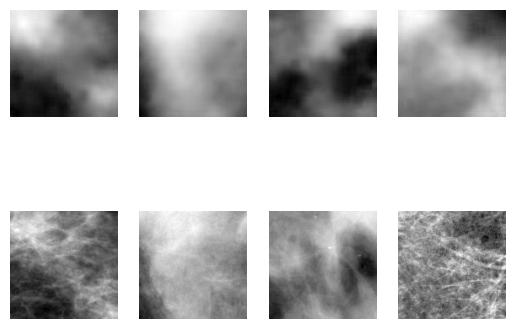

In [ ]:
fig, axs = plt.subplots(2, 4)
# inv_normalize = transforms.Normalize((-1,), (2,))

with torch.no_grad():
    for i, data in enumerate(dataloaders['test'], 0):
        inputs, labels = data['image'].to(device), data['label'].to(device)

        outputs = ae(inputs)

        for ax, reconstructed, original in zip(range(4), outputs[0], inputs):
            # reconstructed = inv_normalize(reconstructed)      # unnormalize
            # original = inv_normalize(original)                # unnormalize
            # original = original / 2 + 0.5     # unnormalize
            # print(reconstructed[0])
            # print(original[0])

            axs[0][ax].imshow(reconstructed[0].cpu(), cmap='gray')
            # axs[0][ax].imshow(reconstructed.cpu().permute(1,2,0))
            axs[1][ax].imshow(original[0].cpu(), cmap='gray')
            # axs[1][ax].imshow(original.cpu().permute(1,2,0))
            axs[0][ax].axis('off')
            axs[1][ax].axis('off')
        plt.show()

        break

## Self Supervised Big

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, device=None):
        super().__init__()
        if device is None:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = device

        self.encoder = nn.Sequential(
            nn.Conv2d(n_channels, 512, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(512, 256, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(256, 128, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 64, 3),
            nn.ReLU(),
            nn.Flatten(1),
            nn.Linear(64 * 12 * 12, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
        )
        self.distribution_mean = nn.Linear(64, 32)
        self.distribution_variance = nn.Linear(64, 32)

        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            torch.nn.Unflatten(1, (128, 1, 1)),
            nn.ConvTranspose2d(128, 64, 12),
            # nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 128, 3),
            # nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(128, 256, 3),
            # nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(256, 512, 4),
            # nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(512, n_channels, 3),
            nn.Sigmoid(),
        )


    def forward(self, x):
        input = x

        x = self.encoder(x)
        mean, var = self.distribution_mean(x), self.distribution_variance(x)
        x = self.sample_latent_features([mean, var])
        latent = x
        x = self.decoder(x)

        rec_loss = get_reconstruction_loss(input, x)
        kl_loss =  get_kl_loss(mean, var)
        loss = rec_loss + kl_loss

        return x, latent, dict(rec_loss=rec_loss, kl_loss=kl_loss), loss

    def sample_latent_features(self, distribution):
        # if not self.training: return distribution[0]
        distribution_mean, distribution_variance = distribution
        shape = distribution_variance.shape
        batch_size = shape[0]
        random = torch.normal(mean=0, std=1, size=(batch_size, shape[1])).to(self.device)
        return distribution_mean + torch.exp(0.5 * distribution_variance) * random

ae = Autoencoder()

In [ ]:
summary(ae, input_size=(32, n_channels, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder                              [32, 1, 128, 128]         --
├─Sequential: 1-1                        [32, 64]                  --
│    └─Conv2d: 2-1                       [32, 512, 126, 126]       5,120
│    └─ReLU: 2-2                         [32, 512, 126, 126]       --
│    └─MaxPool2d: 2-3                    [32, 512, 63, 63]         --
│    └─Conv2d: 2-4                       [32, 256, 61, 61]         1,179,904
│    └─ReLU: 2-5                         [32, 256, 61, 61]         --
│    └─MaxPool2d: 2-6                    [32, 256, 30, 30]         --
│    └─Conv2d: 2-7                       [32, 128, 28, 28]         295,040
│    └─ReLU: 2-8                         [32, 128, 28, 28]         --
│    └─MaxPool2d: 2-9                    [32, 128, 14, 14]         --
│    └─Conv2d: 2-10                      [32, 64, 12, 12]          73,792
│    └─ReLU: 2-11                        [32, 64, 12, 12]         

In [ ]:
optimizer = optim.Adam(ae.parameters())

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ae.to(device)

hist = train(ae, optimizer, dataloaders['train'], dataloaders['val'], 20)
# hist = train(ae, optimizer, dataloader, dataloaders['val'], 100)

[epoch: 1] - train_loss: 11034.2419 - train_rec_loss: 11031.9428 - train_kl_loss: 2.2991 - val_loss: 10384.9051 - val_rec_loss: 10379.8359 - val_kl_loss: 5.0692
[epoch: 2] - train_loss: 10378.1045 - train_rec_loss: 10372.3725 - train_kl_loss: 5.7320 - val_loss: 10229.7986 - val_rec_loss: 10224.4263 - val_kl_loss: 5.3722
[epoch: 3] - train_loss: 10258.7459 - train_rec_loss: 10253.2863 - train_kl_loss: 5.4596 - val_loss: 10150.0889 - val_rec_loss: 10144.8199 - val_kl_loss: 5.2690
[epoch: 4] - train_loss: 10210.3350 - train_rec_loss: 10205.1247 - train_kl_loss: 5.2103 - val_loss: 10124.5238 - val_rec_loss: 10119.7276 - val_kl_loss: 4.7962
[epoch: 5] - train_loss: 10179.5348 - train_rec_loss: 10174.5820 - train_kl_loss: 4.9528 - val_loss: 10093.8128 - val_rec_loss: 10088.9103 - val_kl_loss: 4.9025
[epoch: 6] - train_loss: 10156.8252 - train_rec_loss: 10151.8946 - train_kl_loss: 4.9306 - val_loss: 10082.8729 - val_rec_loss: 10078.0004 - val_kl_loss: 4.8724
[epoch: 7] - train_loss: 10141.639

In [ ]:
test_metrics = validate(ae, dataloaders['test'])

print(get_metrics_str(test_metrics, len(dataloaders['test']), 'test_'))

 - test_loss: 10006.6479 - test_rec_loss: 10002.3176 - test_kl_loss: 4.3302


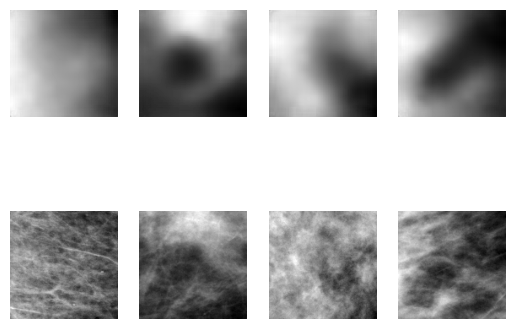

In [ ]:
fig, axs = plt.subplots(2, 4)
# inv_normalize = transforms.Normalize((-1,), (2,))

with torch.no_grad():
    for i, data in enumerate(dataloaders['test'], 0):
        inputs, labels = data['image'].to(device), data['label'].to(device)

        outputs = ae(inputs)

        for ax, reconstructed, original in zip(range(4), outputs[0], inputs):
            # reconstructed = inv_normalize(reconstructed)      # unnormalize
            # original = inv_normalize(original)                # unnormalize
            # original = original / 2 + 0.5     # unnormalize
            # print(reconstructed[0])
            # print(original[0])

            axs[0][ax].imshow(reconstructed[0].cpu(), cmap='gray')
            # axs[0][ax].imshow(reconstructed.cpu().permute(1,2,0))
            axs[1][ax].imshow(original[0].cpu(), cmap='gray')
            # axs[1][ax].imshow(original.cpu().permute(1,2,0))
            axs[0][ax].axis('off')
            axs[1][ax].axis('off')
        plt.show()

        break

In [ ]:
hist

[({'loss': 65093.92233276367,
   'rec_loss': 64878.10494995117,
   'kl_loss': 215.81736260140315},
  {'loss': 4679.091888427734,
   'rec_loss': 4631.804443359375,
   'kl_loss': 47.287442684173584}),
 ({'loss': 32307.544860839844,
   'rec_loss': 31918.601623535156,
   'kl_loss': 388.9432764053345},
  {'loss': 3593.7886962890625,
   'rec_loss': 3539.439437866211,
   'kl_loss': 54.34925150871277}),
 ({'loss': 25521.710525512695,
   'rec_loss': 25095.06526184082,
   'kl_loss': 426.6452214717865},
  {'loss': 3090.668899536133,
   'rec_loss': 3035.026336669922,
   'kl_loss': 55.64256000518799}),
 ({'loss': 22411.539123535156,
   'rec_loss': 21976.111526489258,
   'kl_loss': 435.4275379180908},
  {'loss': 2835.3280334472656,
   'rec_loss': 2779.7750091552734,
   'kl_loss': 55.55302929878235}),
 ({'loss': 21420.519409179688,
   'rec_loss': 20981.629653930664,
   'kl_loss': 438.8897759914398},
  {'loss': 2805.0140838623047,
   'rec_loss': 2747.071319580078,
   'kl_loss': 57.942768573760986}),
 

## Other Losses

In [ ]:
def get_reconstruction_loss(y_true, y_pred, device='cuda'):
    reconstruction_loss = F.binary_cross_entropy(y_pred, y_true, reduction='sum').to(device)
    reconstruction_loss = (reconstruction_loss)/y_pred.shape[0]

    return reconstruction_loss

class Autoencoder(nn.Module):
    def __init__(self, device=None):
        super().__init__()
        if device is None:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = device

        self.encoder = nn.Sequential(
            nn.Conv2d(n_channels, 512, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(512, 256, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(256, 128, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 64, 3),
            nn.ReLU(),
            nn.Flatten(1),
            nn.Linear(64 * 12 * 12, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
        )
        self.distribution_mean = nn.Linear(64, 32)
        self.distribution_variance = nn.Linear(64, 32)

        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            torch.nn.Unflatten(1, (128, 1, 1)),
            nn.ConvTranspose2d(128, 64, 12),
            # nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 128, 3),
            # nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(128, 256, 3),
            # nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(256, 512, 4),
            # nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(512, n_channels, 3),
            nn.Sigmoid(),
        )


    def forward(self, x):
        input = x

        x = self.encoder(x)
        mean, var = self.distribution_mean(x), self.distribution_variance(x)
        x = self.sample_latent_features([mean, var])
        latent = x
        x = self.decoder(x)

        rec_loss = get_reconstruction_loss(input, x)
        kl_loss =  get_kl_loss(mean, var)
        loss = rec_loss + kl_loss

        return x, latent, dict(rec_loss=rec_loss, kl_loss=kl_loss), loss

    def sample_latent_features(self, distribution):
        # if not self.training: return distribution[0]
        distribution_mean, distribution_variance = distribution
        shape = distribution_variance.shape
        batch_size = shape[0]
        random = torch.normal(mean=0, std=1, size=(batch_size, shape[1])).to(self.device)
        return distribution_mean + torch.exp(0.5 * distribution_variance) * random

ae = Autoencoder()

In [ ]:
summary(ae, input_size=(32, n_channels, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder                              [32, 1, 128, 128]         --
├─Sequential: 1-1                        [32, 64]                  --
│    └─Conv2d: 2-1                       [32, 512, 126, 126]       5,120
│    └─ReLU: 2-2                         [32, 512, 126, 126]       --
│    └─MaxPool2d: 2-3                    [32, 512, 63, 63]         --
│    └─Conv2d: 2-4                       [32, 256, 61, 61]         1,179,904
│    └─ReLU: 2-5                         [32, 256, 61, 61]         --
│    └─MaxPool2d: 2-6                    [32, 256, 30, 30]         --
│    └─Conv2d: 2-7                       [32, 128, 28, 28]         295,040
│    └─ReLU: 2-8                         [32, 128, 28, 28]         --
│    └─MaxPool2d: 2-9                    [32, 128, 14, 14]         --
│    └─Conv2d: 2-10                      [32, 64, 12, 12]          73,792
│    └─ReLU: 2-11                        [32, 64, 12, 12]         

In [ ]:
optimizer = optim.Adam(ae.parameters())

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ae.to(device)

hist = train(ae, optimizer, dataloaders['train'], dataloaders['val'], 5)
# hist = train(ae, optimizer, dataloader, dataloaders['val'], 100)

[epoch: 1] - train_loss: 10918.5569 - train_rec_loss: 10914.2265 - train_kl_loss: 4.3304 - val_loss: 10353.8691 - val_rec_loss: 10347.1681 - val_kl_loss: 6.7010


KeyboardInterrupt: ignored

In [ ]:
test_metrics = validate(ae, dataloaders['test'])

print(get_metrics_str(test_metrics, len(dataloaders['test']), 'test_'))

In [ ]:
fig, axs = plt.subplots(2, 4)
# inv_normalize = transforms.Normalize((-1,), (2,))

with torch.no_grad():
    for i, data in enumerate(dataloaders['test'], 0):
        inputs, labels = data['image'].to(device), data['label'].to(device)

        outputs = ae(inputs)

        for ax, reconstructed, original in zip(range(4), outputs[0], inputs):
            # reconstructed = inv_normalize(reconstructed)      # unnormalize
            # original = inv_normalize(original)                # unnormalize
            # original = original / 2 + 0.5     # unnormalize
            # print(reconstructed[0])
            # print(original[0])

            axs[0][ax].imshow(reconstructed[0].cpu(), cmap='gray')
            # axs[0][ax].imshow(reconstructed.cpu().permute(1,2,0))
            axs[1][ax].imshow(original[0].cpu(), cmap='gray')
            # axs[1][ax].imshow(original.cpu().permute(1,2,0))
            axs[0][ax].axis('off')
            axs[1][ax].axis('off')
        plt.show()

        break

In [ ]:
hist

[({'loss': 65093.92233276367,
   'rec_loss': 64878.10494995117,
   'kl_loss': 215.81736260140315},
  {'loss': 4679.091888427734,
   'rec_loss': 4631.804443359375,
   'kl_loss': 47.287442684173584}),
 ({'loss': 32307.544860839844,
   'rec_loss': 31918.601623535156,
   'kl_loss': 388.9432764053345},
  {'loss': 3593.7886962890625,
   'rec_loss': 3539.439437866211,
   'kl_loss': 54.34925150871277}),
 ({'loss': 25521.710525512695,
   'rec_loss': 25095.06526184082,
   'kl_loss': 426.6452214717865},
  {'loss': 3090.668899536133,
   'rec_loss': 3035.026336669922,
   'kl_loss': 55.64256000518799}),
 ({'loss': 22411.539123535156,
   'rec_loss': 21976.111526489258,
   'kl_loss': 435.4275379180908},
  {'loss': 2835.3280334472656,
   'rec_loss': 2779.7750091552734,
   'kl_loss': 55.55302929878235}),
 ({'loss': 21420.519409179688,
   'rec_loss': 20981.629653930664,
   'kl_loss': 438.8897759914398},
  {'loss': 2805.0140838623047,
   'rec_loss': 2747.071319580078,
   'kl_loss': 57.942768573760986}),
 

## Self Supervised

In [ ]:
samplers = {}
randomized_loaders ={}
for s in ['train', 'test', 'val']:
    samplers[s] = RandomSampler(datasets[s], num_samples=batch_size, replacement=True)
    randomized_loaders[s] = DataLoader(datasets[s], batch_size, sampler=samplers[s])

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, device=None):
        super().__init__()
        if device is None:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = device

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 256, 5),
            # nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(256, 128, 3),
            # nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 64, 3),
            # nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(1),
            nn.Linear(64 * 14 * 14, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
        )
        self.distribution_mean = nn.Linear(64, 32)
        self.distribution_variance = nn.Linear(64, 32)

        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            torch.nn.Unflatten(1, (128, 1, 1)),
            nn.ConvTranspose2d(128, 64, 14),
            # nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(64, 128, 3),
            # nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(128, 256, 3),
            # nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(256, 1, 5),
            nn.Tanh(),
        )


    def forward(self, x, other=None):
        input = x

        x = self.encoder(x)
        mean, var = self.distribution_mean(x), self.distribution_variance(x)
        x = self.sample_latent_features([mean, var])
        latent = x
        x = self.decoder(x)

        rec_loss = get_reconstruction_loss(input, x)
        weighted_rec_loss = rec_loss
        kl_loss =  get_kl_loss(mean, var)

        metrics = dict(rec_loss=rec_loss, kl_loss=kl_loss)

        if other is not None:
            other_x, same = other
            other_x = self.encoder(other_x)
            mean, var = self.distribution_mean(other_x), self.distribution_variance(other_x)
            other_latent = self.sample_latent_features([mean, var])
            embed_loss = embedding_loss(latent, other_latent, same)
            weighted_rec_loss = weighted_rec_loss * embed_loss
            metrics['weighted_rec_loss'] = weighted_rec_loss

        loss = weighted_rec_loss + kl_loss

        # x, latent, metrics, loss
        return x, latent, metrics, loss

    def sample_latent_features(self, distribution):
        # if not self.training: return distribution[0]
        distribution_mean, distribution_variance = distribution
        shape = distribution_variance.shape
        batch_size = shape[0]
        random = torch.normal(mean=0, std=1, size=(batch_size, shape[1])).to(self.device)
        return distribution_mean + torch.exp(0.5 * distribution_variance) * random

ae = Autoencoder()

In [ ]:
summary(ae, input_size=(32, 1, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder                              [32, 1, 128, 128]         --
├─Sequential: 1-1                        [32, 64]                  --
│    └─Conv2d: 2-1                       [32, 256, 124, 124]       6,656
│    └─ReLU: 2-2                         [32, 256, 124, 124]       --
│    └─MaxPool2d: 2-3                    [32, 256, 62, 62]         --
│    └─Conv2d: 2-4                       [32, 128, 60, 60]         295,040
│    └─ReLU: 2-5                         [32, 128, 60, 60]         --
│    └─MaxPool2d: 2-6                    [32, 128, 30, 30]         --
│    └─Conv2d: 2-7                       [32, 64, 28, 28]          73,792
│    └─ReLU: 2-8                         [32, 64, 28, 28]          --
│    └─MaxPool2d: 2-9                    [32, 64, 14, 14]          --
│    └─Flatten: 2-10                     [32, 12544]               --
│    └─Linear: 2-11                      [32, 128]                 1,605,

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

optimizer = optim.Adam(ae.parameters())

In [ ]:
for d in dataloaders['train']:
    inputs, labels = d['image'].to(device), d['label'].to(device)

    optimizer.zero_grad()

    rand_batch = next(iter(randomized_loaders['train']))
    rand_inputs, rand_labels = rand_batch['image'].to(device), rand_batch['label'].to(device)
    if inputs.shape[0] != rand_inputs.shape[0]:
        rand_inputs = rand_inputs[:inputs.shape[0]]
        rand_labels = rand_labels[:inputs.shape[0]]

    outputs = ae(inputs, (rand_inputs, labels == rand_labels))

OutOfMemoryError: ignored

In [ ]:
hist = train(ae, optimizer, dataloaders['train'], dataloaders['val'], 20, SSL=(randomized_loaders['train'], randomized_loaders['val']))

[epoch: 1] - train_loss: 13.4402 - train_rec_loss: 157.8268 - train_kl_loss: 0.5427 - train_weighted_rec_loss: 12.8975 - val_loss: 10.5238 - val_rec_loss: 126.6073 - val_kl_loss: 0.5855 - val_weighted_rec_loss: 9.9383
[epoch: 2] - train_loss: 12.5781 - train_rec_loss: 147.1440 - train_kl_loss: 0.5040 - train_weighted_rec_loss: 12.0741 - val_loss: 10.1898 - val_rec_loss: 128.2014 - val_kl_loss: 0.4704 - val_weighted_rec_loss: 9.7194
[epoch: 3] - train_loss: 10.4092 - train_rec_loss: 132.6879 - train_kl_loss: 0.4646 - train_weighted_rec_loss: 9.9446 - val_loss: 10.3639 - val_rec_loss: 124.8828 - val_kl_loss: 0.4014 - val_weighted_rec_loss: 9.9625
[epoch: 4] - train_loss: 10.2528 - train_rec_loss: 128.2307 - train_kl_loss: 0.4306 - train_weighted_rec_loss: 9.8222 - val_loss: 8.9659 - val_rec_loss: 116.2366 - val_kl_loss: 0.4433 - val_weighted_rec_loss: 8.5227
[epoch: 5] - train_loss: 10.1682 - train_rec_loss: 127.6152 - train_kl_loss: 0.4587 - train_weighted_rec_loss: 9.7095 - val_loss: 1

In [ ]:
test_metrics = validate(ae, dataloaders['test'], randomized_loaders['test'])

print(get_metrics_str(test_metrics, len(dataloaders['test']), 'test_'))

 - test_loss: 7.1922 - test_rec_loss: 81.3392 - test_kl_loss: 0.4164 - test_weighted_rec_loss: 6.7758


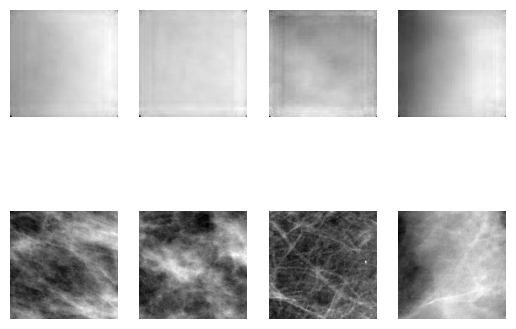

In [ ]:
fig, axs = plt.subplots(2, 4)

with torch.no_grad():
    for i, data in enumerate(dataloaders['test'], 0):
        inputs, labels = data['image'].to(device), data['label'].to(device)

        outputs = ae(inputs)

        for ax, reconstructed, original in zip(range(4), outputs[0], inputs):
            # img = img / 2 + 0.5     # unnormalize
            # print(reconstructed)
            # print(original)

            axs[0][ax].imshow(reconstructed[0].cpu(), cmap='gray')
            axs[1][ax].imshow(original[0].cpu(), cmap='gray')
            axs[0][ax].axis('off')
            axs[1][ax].axis('off')
        plt.show()

        break